# Neural Network Dev Notebook

This notebook is for development of a suitable neural network for training on the training set. Here, I use the dev set and tune hyperparameters and model structure for best performance. 

In [1]:
import keras
import glob
import os
from PIL import Image
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Lambda, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from utils import load_json, make_logger
import logging
import itertools
import pickle

params = load_json('params.json')
logger = make_logger('development', 'log/development.log')

Using TensorFlow backend.


## Load the dev set and images

Creates a dict relating artist MBIDs to spectrogram images, represented as 128x128x1 arrays of floats. Also load the previously saved database of artist relationships.

For now, we only load the first track we have on file for each artist, even if we have more. This can be changed later.

In [2]:
logger.info('Loading images')

images = defaultdict(list)

for path in tqdm_notebook(glob.glob('tracks/**/*.png', recursive=True)):
    mbid = os.path.basename(path).rsplit('-', 1)[0]
    img = np.array(Image.open(path).convert('L')) / 255
    img = np.reshape(img, img.shape + (1,))
    images[mbid].append(img)
    
logger.info('Loaded images')

Loading images


Loaded images


In [19]:
logger.info('Loading dev set')

raw_dataset = pd.read_hdf('dataset/dev_min.hd5', key='artists')

logger.info('Loaded dev set')

Loading dev set
Loaded dev set


In [20]:
logger.info('Artists in images: {}'.format(len(images)))
logger.info('Dataset length: {}'.format(len(raw_dataset)))

Artists in images: 9484
Dataset length: 4656


In [23]:
unstackeddf = raw_dataset.unstack(fill_value = 0)
display(unstackeddf)
display(unstackeddf.T)

,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,013fa897-86db-41d3-8e9f-386c8a34f4e6,01809552-4f87-45b0-afff-2c6f0730a3be,0741b30d-e15b-4a8c-b2e5-8834a03d6116,07eb40a2-2914-439c-a01d-15a685b84ddf,09885b8e-f235-4b80-a02a-055539493173,0ef3f425-9bd2-4216-9dd2-219d2fe90f1f,10bf95b6-30e3-44f1-817f-45762cdc0de0,11c6b106-1c1f-429d-8407-b1ee155d7f72,12d432a3-feb0-49b1-a107-d20751880764,...,db3c0a20-bf05-4b30-ac22-f294aea24172,db4624cf-0e44-481e-a9dc-2142b833ec2f,db76c5ca-d555-4f09-b1db-baa1b713d875,de11b037-d880-40e0-8901-0397c768c457,e0953daa-860f-4dc8-9f1a-b12587cdaf17,e5c7b94f-e264-473c-bb0f-37c85d4d5c70,e618770f-e994-41c3-856f-1eedf56b6d74,e6e879c0-3d56-4f12-b3c5-3ce459661a8e,eab76c9f-ff91-4431-b6dd-3b976c598020,f83781c8-64f9-4657-85bd-51f74d195cfd
013fa897-86db-41d3-8e9f-386c8a34f4e6,0.116682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
01809552-4f87-45b0-afff-2c6f0730a3be,0.062196,0.113016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0741b30d-e15b-4a8c-b2e5-8834a03d6116,0.094349,0.037083,0.018523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
07eb40a2-2914-439c-a01d-15a685b84ddf,0.009675,0.049653,0.037913,0.016940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
09885b8e-f235-4b80-a02a-055539493173,0.135232,0.017389,0.035164,0.023610,0.003892,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0ef3f425-9bd2-4216-9dd2-219d2fe90f1f,0.030407,0.041902,0.096520,0.016254,0.009808,0.040993,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10bf95b6-30e3-44f1-817f-45762cdc0de0,0.005892,0.017389,0.013602,0.001270,0.004233,0.005708,0.017095,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11c6b106-1c1f-429d-8407-b1ee155d7f72,0.036081,0.016970,0.018812,0.045975,0.044686,0.012453,0.028304,0.003810,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12d432a3-feb0-49b1-a107-d20751880764,0.068525,0.076261,0.073945,0.025340,0.016126,0.024388,0.051004,0.025340,0.022173,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16231a34-9ccd-410e-8690-f74e98fe16a4,0.006620,0.006285,0.012011,0.001093,0.008937,0.004411,0.010089,0.027939,0.017616,0.017565,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,013fa897-86db-41d3-8e9f-386c8a34f4e6,01809552-4f87-45b0-afff-2c6f0730a3be,0741b30d-e15b-4a8c-b2e5-8834a03d6116,07eb40a2-2914-439c-a01d-15a685b84ddf,09885b8e-f235-4b80-a02a-055539493173,0ef3f425-9bd2-4216-9dd2-219d2fe90f1f,10bf95b6-30e3-44f1-817f-45762cdc0de0,11c6b106-1c1f-429d-8407-b1ee155d7f72,12d432a3-feb0-49b1-a107-d20751880764,16231a34-9ccd-410e-8690-f74e98fe16a4,...,db4624cf-0e44-481e-a9dc-2142b833ec2f,db76c5ca-d555-4f09-b1db-baa1b713d875,de11b037-d880-40e0-8901-0397c768c457,e0953daa-860f-4dc8-9f1a-b12587cdaf17,e5c7b94f-e264-473c-bb0f-37c85d4d5c70,e618770f-e994-41c3-856f-1eedf56b6d74,e6e879c0-3d56-4f12-b3c5-3ce459661a8e,eab76c9f-ff91-4431-b6dd-3b976c598020,f83781c8-64f9-4657-85bd-51f74d195cfd,fa927f59-d443-418a-b741-e557208aaf09
0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,0.116682,0.062196,0.094349,0.009675,0.135232,0.030407,0.005892,0.036081,0.068525,0.006620,...,0.044229,0.006983,0.031207,0.021605,0.405113,0.083947,0.106716,0.033826,0.068161,0.117773
013fa897-86db-41d3-8e9f-386c8a34f4e6,0.000000,0.113016,0.037083,0.049653,0.017389,0.041902,0.017389,0.016970,0.076261,0.006285,...,0.081908,0.011732,0.033940,0.019484,0.268192,0.071233,0.137647,0.024303,0.065157,0.094279
01809552-4f87-45b0-afff-2c6f0730a3be,0.000000,0.000000,0.018523,0.037913,0.035164,0.096520,0.013602,0.018812,0.073945,0.012011,...,0.167282,0.015918,0.035309,0.006657,0.111522,0.053108,0.072209,0.047175,0.018957,0.022140
0741b30d-e15b-4a8c-b2e5-8834a03d6116,0.000000,0.000000,0.000000,0.016940,0.023610,0.016254,0.001270,0.045975,0.025340,0.001093,...,0.008026,0.004918,0.100727,0.019125,0.067344,0.065878,0.071435,0.009596,0.084329,0.046019
07eb40a2-2914-439c-a01d-15a685b84ddf,0.000000,0.000000,0.000000,0.000000,0.003892,0.009808,0.004233,0.044686,0.016126,0.008937,...,0.008232,0.004129,0.030167,0.012786,0.028231,0.020372,0.015289,0.010064,0.016108,0.006574
09885b8e-f235-4b80-a02a-055539493173,0.000000,0.000000,0.000000,0.000000,0.000000,0.040993,0.005708,0.012453,0.024388,0.004411,...,0.068531,0.012453,0.010118,0.000519,0.023597,0.129723,0.027501,0.028085,0.007005,0.040214
0ef3f425-9bd2-4216-9dd2-219d2fe90f1f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017095,0.028304,0.051004,0.010089,...,0.207240,0.058010,0.031107,0.003083,0.018425,0.070112,0.070117,0.041426,0.026343,0.021859
10bf95b6-30e3-44f1-817f-45762cdc0de0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003810,0.025340,0.027939,...,0.013583,0.000847,0.019473,0.004233,0.003233,0.004498,0.015816,0.047745,0.001693,0.028617
11c6b106-1c1f-429d-8407-b1ee155d7f72,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022173,0.017616,...,0.013377,0.030077,0.057146,0.025350,0.036528,0.025928,0.034004,0.033469,0.039530,0.025523
12d432a3-feb0-49b1-a107-d20751880764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017565,...,0.061328,0.006335,0.021309,0.021885,0.102471,0.056618,0.089623,0.048213,0.062199,0.066231


## Create dataset relating image references to values

Previously, we had the large raw dataset which is of the form `raw_dataset[artistA][artistB]=similarity`. Here, we create X and Y arrays, with the X array being a list of two arrays, each containing references to one of the spectrogram images that was loaded for a given artist. The Y array is a list containing the similarity scores for the corresponding two artists.

In [114]:
logger.info('Re-formatting dataset for training')

X_1 = list()
X_2 = list()
Y = list()

for index, value in tqdm_notebook(raw_dataset.iteritems(), total = len(raw_dataset)):
    artist_A = index[0]
    artist_B = index[1]
    audio_A = images[artist_A]
    audio_B = images[artist_B]
        
    for pair in itertools.product(audio_A, audio_B):
        X_1.append(pair[0])
        X_2.append(pair[1])
        Y.append(value)
    
# Create dev train and dev test sets
X_1_train, X_1_test, X_2_train, X_2_test, Y_train, Y_test = train_test_split(X_1, X_2, Y, test_size=0.25, 
                                                                             random_state = 1)
logger.info('Training set size: {}'.format(len(Y_train)))
logger.info('Test set size: {}'.format(len(Y_test)))
X_train = [X_1_train, X_2_train]
X_test = [X_1_test, X_2_test]
# We make Y a numpy array for convenience later, this cant be done with X because it doesn't fit in memory
Y = np.array(Y)
X = [X_1, X_2]

logger.info('Dataset formatted')

Re-formatting dataset for training


Training set size: 29283
Test set size: 9761
Dataset formatted


## Batch Function

Gets a batch of a specific batch size, either from the dev-train set or dev-test set. Uses random sampling with replacement.

In [115]:
def get_batch(batch_size, train = True):
    if train:
        X = X_train
        Y = Y_train
    else:
        X = X_test
        Y = Y_test
    indices = np.random.choice(len(Y), size = batch_size)
    X_batch = [list(), list()]
    X_batch[0] = [X[0][i] for i in indices]
    X_batch[1] = [X[1][i] for i in indices]
    Y_batch = [Y[i] for i in indices]
    return X_batch, Y_batch

## Define Keras model specification

This defines a siamese network, which trains the same model with the same parameters and applies it to both images. The output of this shared vector is a fully-connected network with 128 neurons, for each image. The L1 distance between these two networks is then taken and the resulting 128 length vector is fed into a final sigmoid function.

In [166]:
def L1_distance(x):
    return K.abs(x[0] - x[1])

def L1_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1

def create_base_network(input_shape):
    input = Input(shape = input_shape)
    x = ZeroPadding2D()(input) # 130x130x1
    x = Conv2D(8,(3,3),activation='tanh')(x) # 128x128x8
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 64x64x8
    x = ZeroPadding2D()(x) # 66x66x8
    x = Conv2D(16,(3,3),activation='tanh')(x) # 64x64x16
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 32x32x16
    x = ZeroPadding2D()(x) # 34x34x16
    x = Conv2D(32,(3,3),activation='tanh')(x) # 32x32x32
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 16x16x32
    x = ZeroPadding2D()(x) # 18x18x32
    x = Conv2D(64,(3,3),activation='tanh')(x) # 16x16x64
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x) # 8x8x64
    x = ZeroPadding2D()(x) # 10x10x64
    x = Conv2D(128,(7,7),activation='tanh')(x) # 4x4x128
    x = Flatten()(x) # vector len 2048
    x = Dense(512, activation='tanh')(x) # FC 512
    return Model(input, x)
    
def model_spec(lr = 0.001, decay = 0.0, **kwargs):
    input_shape = (128,128,1)

    siamese_net = create_base_network(input_shape)

    input_a = Input(shape = input_shape)
    input_b = Input(shape = input_shape)

    process_a = siamese_net(input_a)
    process_b = siamese_net(input_b)

    distance = Lambda(L1_distance, output_shape = L1_dist_output_shape)([process_a, process_b])

    output = Dense(1, activation='sigmoid')(distance)

    model = Model([input_a, input_b], output)

    adam = Adam(lr=lr, decay=decay)
    model.compile(loss = 'mean_squared_error', optimizer = adam)
    
    return model

## Hyperparameter Search

This function will take in a model and a hyperparameters dict, and output training and test losses after training. The following hyperparameters are implemented:

`batch_size`: batch size for training

`epochs`: number of epochs to use in the training phase

`lr`: learning rate for model

`decay`: decay for learning rate

`expon_weight`: scale of exponential loss weighting

In [167]:
def build_model_path(hparams):
    path_components = ['_'.join([key, str(val)]) for key,val in hparams.items()]
    return os.path.join('models', *path_components)

def test_hyperparams(hparams, model_spec, log=True, save=True):
    # Make the path to the logger/model directory, named based on parameters
    path = build_model_path(hparams)
    os.makedirs(path, exist_ok=True)
    
    # Get temporary logger with hparams.__str__ name 
    tmp_logger = make_logger(str(hparams), os.path.join(path, 'training.log'), log_to_console=False)
    
    batch_size = hparams['batch_size']
    epochs = hparams['epochs']
    model = model_spec(**hparams)
    expon_weight = hparams['expon_weight']

    tmp_logger.info('Training with params {}'.format(hparams))
    
    train_weights = np.exp(5 * np.array(Y_train)) / (np.sum(np.exp(5 * np.array(Y_train))))
    train_weights /= np.mean(train_weights)
    test_weights = np.exp(5 * np.array(Y_test)) / (np.sum(np.exp(5 * np.array(Y_test))))
    test_weights /= np.mean(test_weights)

    history = model.fit(X_train, Y_train, epochs=epochs, class_weight=train_weights,
                    validation_data=(X_test, Y_test, test_weights), batch_size=batch_size)
    
    tmp_logger.info('Finished training, final train loss = {:.5f}, test loss = {:.5f}'.format(
        history.history['loss'][-1], history.history['val_loss'][-1]))
    
    with open(os.path.join(path, 'history'), 'wb') as file:
        pickle.dump(history.history, file)
    
    if save:
        tmp_logger.info('Saving model')
        model.save(os.path.join(path, 'post_train_model.hd5'))
        tmp_logger.info('Saved model')
        

## Iterate through Hyperparameter sets and Evaluate

Create a dict containing all values for all hyperparameters we want to look at, then generate all combinations of these parameters and test each one.

In [169]:
all_hparams = {
    'batch_size': [64, 128, 256],
    'epochs': [5, 10, 25], 
    'lr': [0.1, 0.01, 0.001],
    'expon_weight': [0, 2.5, 5]
}

hparams_list = list()
keys, vals = zip(*all_hparams.items())
for val in itertools.product(*vals):
    hparams_list.append(dict(zip(keys, val)))

logger.info('Generated hyperparameters test list, total of {} combinations'.format(len(hparams_list)))

for hparams in tqdm_notebook(hparams_list):
    print(hparams)
    test_hyperparams(hparams, model_spec)

Generated hyperparameters test list, total of 81 combinations


{'batch_size': 64, 'epochs': 5, 'lr': 0.1, 'expon_weight': 0}


MemoryError: 

## Random checking below

In [172]:
hparams = {
    'batch_size': 256,
    'epochs': 10
}
#test_hyperparams(hparams, model_spec)
model = model_spec()
train_weights = np.exp(5 * np.array(Y_train)) / (np.sum(np.exp(5 * np.array(Y_train))))
train_weights /= np.mean(train_weights)
test_weights = np.exp(5 * np.array(Y_test)) / (np.sum(np.exp(5 * np.array(Y_test))))
test_weights /= np.mean(test_weights)
history = model.fit(X_train, Y_train, epochs=40, class_weight=train_weights,
                    validation_data=(X_test, Y_test, test_weights), batch_size=256)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


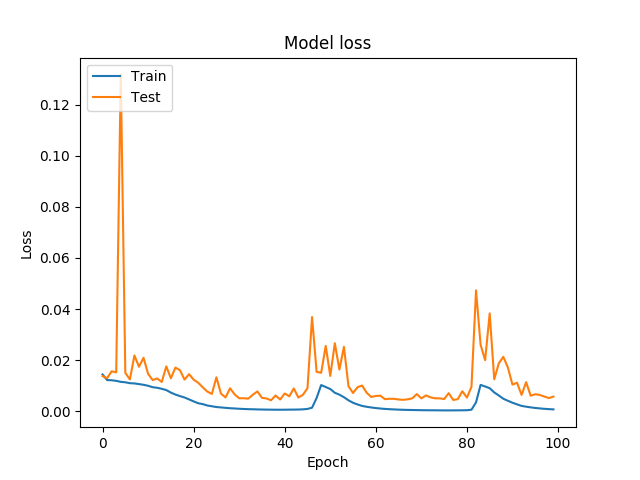

In [77]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [133]:
predictions = model.predict(X_test)

In [134]:
diffs = predictions.reshape(len(predictions),) - np.array(Y_test)

In [135]:
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.nan)
np.sort(diffs)

array([-0.48780833, -0.45673604, -0.45015484, -0.43635383, -0.42629341,
       -0.3989963 , -0.36490441, -0.34190741, -0.33298201, -0.32611794,
       -0.3219133 , -0.31323435, -0.30923945, -0.30141954, -0.29695792,
       -0.27034596, -0.26980722, -0.26972166, -0.26595382, -0.23914996,
       -0.2386357 , -0.23560347, -0.23318355, -0.23276518, -0.23125817,
       -0.2284528 , -0.22342169, -0.22112678, -0.2204803 , -0.21688935,
       -0.21135792, -0.21073134, -0.20947522, -0.20914957, -0.20877703,
       -0.20669238, -0.20618204, -0.20600197, -0.20588912, -0.20431577,
       -0.20021783, -0.19941955, -0.19895009, -0.19834261, -0.19768909,
       -0.19661259, -0.19372694, -0.19216337, -0.19142724, -0.18953544,
       -0.18822155, -0.1879696 , -0.1875145 , -0.18699222, -0.18691842,
       -0.18652098, -0.18647219, -0.18637458, -0.18533143, -0.18490674,
       -0.18235863, -0.18151922, -0.17991644, -0.17891773, -0.17737334,
       -0.17588269, -0.17585549, -0.17554314, -0.1742988 , -0.17

In [109]:
model.save('models/test1.hd5')

In [136]:
raw_dataset.keys

<bound method Series.keys of 99acd557-c4e2-4086-9be9-85f57184dadc  329f95db-f02e-40bf-a5f7-0dea11529ce3    0.011497
9d30e408-1559-448b-b491-2f8de1583ccf  4f8ef4a3-40fa-46b5-8773-97686a8424f4    0.008074
57e79d57-b795-475e-9fa2-5dd9d5513b8c  382f1005-e9ab-4684-afd4-0bdae4ee37f2    0.054666
6e9ac29b-798c-4af7-8d9e-55cdc72a999c  2449300a-6ca7-45da-8102-22789d256475    0.003414
319b1175-ced9-438f-986b-9239c3edd92d  0f96c38b-8e21-4571-afe0-cb11196a8acd    0.003024
f83781c8-64f9-4657-85bd-51f74d195cfd  9941a936-196a-4a62-ae53-a69cbc33f20e    0.009949
847e8284-8582-4b0e-9c26-b042a4f49e57  7e13cd1c-0300-4d03-bd8e-5f86dd99d74f    0.052769
ccd4879c-5e88-4385-b131-bf65296bf245  647221d0-f6b1-4e03-924c-c59b8059536f    0.022247
7b52603c-a84c-4a76-8dc8-899bb4dd9fa7  75af9d25-cf32-49c0-9192-60bd8e9784e6    0.008678
d7311646-287b-4d3a-9a4f-7d46f93075e5  9efff43b-3b29-4082-824e-bc82f646f93d    0.023926
9b58672a-e68e-4972-956e-a8985a165a1f  01d3c51b-9b98-418a-8d8e-37f6fab59d8c    0.035349
234bab50-2f04-

In [138]:
def eval_artist_similarity(mbid_a, mbid_b, model):
    

{'val_loss': [0.016063883909038706,
  0.021938556992452587,
  0.01244439280116464,
  0.010231408770395075,
  0.007686466521842256,
  0.019091805221619584,
  0.020482130407838226,
  0.017363607769339876,
  0.010201306657360147,
  0.02445523233945137,
  0.02050785370680192,
  0.01642638339488651,
  0.012164153744498184,
  0.007258943342797908,
  0.008021363921729882,
  0.04266233113429766,
  0.01474875712402958,
  0.011510915547035327,
  0.008115956161906638,
  0.011596685616058498,
  0.009347342982874483,
  0.010232133412444193,
  0.008717716688319053,
  0.008978616838211677,
  0.015620797935897313,
  0.004983309249733025,
  0.0042791558390861285,
  0.004979843123197775,
  0.005586325810475496],
 'loss': [0.0021192578234889587,
  0.0019999153441595738,
  0.0019568605230633244,
  0.0017902235231109025,
  0.0017018373688603467,
  0.0016627114479277137,
  0.0016464114482653068,
  0.001530902651873599,
  0.001456970411962309,
  0.0014887347750981972,
  0.0015148385321228852,
  0.00143806903

In [146]:
def rank_top_similar(series):
    series.to_frame()

0.0017087382289368654

0.11661232080335901

In [162]:
raw_dataset.groupby(level=1).idxmax()

AttributeError: 'Index' object has no attribute 'labels'

In [161]:
raw_dataset['000fc734-b7e1-4a01-92d1-f544261b43f5']

AttributeError: 'Index' object has no attribute 'labels'